In [4]:
patient_file_link = link_patient_file("link.csv")

In [5]:
from glob import glob
dicom_base_path = "/Users/300012073/Documents/Tutes/final_data/dicoms/"
countour_base_path = "/Users/300012073/Documents/Tutes/final_data/contourfiles/"

    

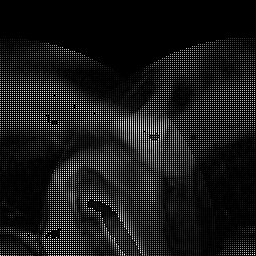

In [10]:
Image.fromarray(c['pixel_data'], mode = "L")

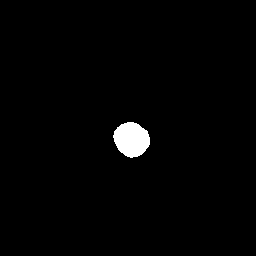

In [11]:
Image.fromarray(np.uint8(d)*255)

In [20]:
BASE_PATH = "./"
DICOM_BASE_PATH = "./dicoms"
CONTOUR_BASE_PATH ="./contourfiles"  
LINK_FILE ="./Link.csv"
OUTPUT_FOLDER = "./output"

In [55]:
def parse_contour_file(filename):
    """Parse the given contour filename

    :param filename: filepath to the contourfile to parse
    :return: list of tuples holding x, y coordinates of the contour
    """

    coords_lst = []

    with open(filename, 'r') as infile:
        for line in infile:
            coords = line.strip().split()

            x_coord = float(coords[0])
            y_coord = float(coords[1])
            coords_lst.append((x_coord, y_coord))

    return coords_lst

def parse_dicom_file(filename):
    """Parse the given DICOM filename

    :param filename: filepath to the DICOM file to parse
    :return: dictionary with DICOM image data
    """

    try:
        dcm = pydicom.read_file(filename)
        dcm_image = dcm.pixel_array

        try:
            intercept = dcm.RescaleIntercept
        except AttributeError:
            intercept = 0.0
        try:
            slope = dcm.RescaleSlope
        except AttributeError:
            slope = 0.0

        if intercept != 0.0 and slope != 0.0:
            dcm_image = dcm_image*slope + intercept
        dcm_dict = {'pixel_data' : dcm_image}
        return dcm_dict
    except InvalidDicomError:
        return None
    
def poly_to_mask(polygon, width=256, height=256):
    """Convert polygon to mask

    :param polygon: list of pairs of x, y coords [(x1, y1), (x2, y2), ...]
     in units of pixels
    :param width: scalar image width
    :param height: scalar image height
    :return: Boolean mask of shape (height, width)
    """

    # http://stackoverflow.com/a/3732128/1410871
    img = Image.new(mode='L', size=(width, height), color=0)
    ImageDraw.Draw(img).polygon(xy=polygon, outline=500, fill=100)
    mask = np.array(img).astype(bool)
    return mask


def link_patient_file(filename=LINK_FILE ,header = True):
    """
    param filename: Name of csv file assuming two columns containing patient_id and original_id.
    param header: If first item is header/column name ( default True) or not.
    :return: list containing tuples of patient_id and corresponding original_id
    """
    linking_list = []
    with open(filename, 'r') as infile:
        for line in infile:
            if header:
                header = False
            else:
                rec = line.strip().split(",")
                patient_id = rec[0]
                original_id = rec[1]
                linking_list.append((patient_id, original_id))
    return linking_list

#patient_file_link = link_patient_file()


def link_dicom_contour(patient_file_link):
    patient_dict = {}
    dic_cont_arr = []
    unknown_idx = []
    for link in patient_file_link:
        dicom_file_path = glob(os.path.join(DICOM_BASE_PATH,link[0])+"/*.dcm")
        icountour_file_path = glob(os.path.join(CONTOUR_BASE_PATH,link[1])+"/i-contours"+"/*.txt")
        assert dicom_file_path !=[]
        assert icountour_file_path !=[]
        try:
            dicom_id_dict = dict(list(map(lambda x: (int(x.split("/")[-1].strip(".dcm")),x),dicom_file_path)))
            contour_id_dict = dict(list(map(lambda x: (int(x.split("/")[-1].split("-icontour-manual")[0].split("-")[-1]),x),icountour_file_path)))
        except:
            print("Please check the file format")
        dic_cont = [] 
        for idx in contour_id_dict.keys():
            try:
                dic_cont.append((dicom_id_dict[idx],contour_id_dict[idx]))
                dicom_arr = parse_dicom_file(dicom_id_dict[idx])
                contour_arr =  poly_to_mask(parse_contour_file(contour_id_dict[idx]),256,256)
                dic_cont_arr.append((dicom_arr,contour_arr ))
            except:
                unknown_idx.append((idx,contour_id_dict[idx]))

        patient_dict[link[0]] = dic_cont
    print("{} contour files unlinked".format(len(unknown_idx)) )
    return dic_cont_arr, patient_dict 

def save_data(OUTPUT_FOLDER, data):
    with open(os.path.join(OUTPUT_FOLDER,'dicom_contour_array.pickle'), 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [56]:
patient_file_link = link_patient_file(LINK_FILE)

In [57]:
patient_file_link

[('SCD0000101', 'SC-HF-I-1'),
 ('SCD0000201', 'SC-HF-I-2'),
 ('SCD0000301', 'SC-HF-I-4'),
 ('SCD0000401', 'SC-HF-I-5'),
 ('SCD0000501', 'SC-HF-I-6')]

In [54]:
patient_dict = {}
dic_cont_arr = []
unknown_idx = []
for link in patient_file_link:
    dicom_file_path = glob(DICOM_BASE_PATH+link[0]+"/*.dcm")
    icountour_file_path = glob(CONTOUR_BASE_PATH+link[1]+"/i-contours"+"/*.txt")
    assert dicom_file_path !=[]
    assert icountour_file_path !=[]
    try:
        dicom_id_dict = dict(list(map(lambda x: (int(x.split("/")[-1].strip(".dcm")),x),dicom_file_path)))
        contour_id_dict = dict(list(map(lambda x: (int(x.split("/")[-1].split("-icontour-manual")[0].split("-")[-1]),x),icountour_file_path)))
    except:
        print("Please check the file format")
    dic_cont = [] 

    for idx in contour_id_dict.keys():
        try:
            dic_cont.append((dicom_id_dict[idx],contour_id_dict[idx]))
            dic_cont_arr.append((parse_dicom_file(dicom_id_dict[idx]), poly_to_mask(parse_contour_file(contour_id_dict[idx]),256,256)))
        except:
            unknown_idx.append((idx,contour_id_dict[idx]))

    patient_dict[link[0]] = dic_cont
print("{} contour files unlinked".format(len(unknown_idx)) )


AssertionError: 

In [58]:
patient_file_link = link_patient_file(LINK_FILE)
patient_dicom_contour_dict, patient_dicom_contour_path = link_dicom_contour(patient_file_link)
#save_data(OUTPUT_FOLDER,patient_dicom_contour_dict)

0 contour files unlinked


In [60]:
len(patient_dicom_contour_dict)

96

In [61]:
96/8

12.0